Background
Cirrhosis results from prolonged liver damage, leading to extensive scarring, often due to
conditions like hepatitis or chronic alcohol consumption. The data provided is a subset sourced
from a Mayo Clinic study on primary biliary cirrhosis (PBC) of the liver carried out from 1974
to 1984.
This is a dataset to develop and validate machine learning algorithms for predicting the survival
status of the collected patients. There are 312 patients in the data set (224 for train and 88 for
test), and each patient has 17 collected features. The aim of this task is to utilize 17 clinical
features for predicting survival state of patients with liver cirrhosis. The survival states include
0 = D (death), 1 = C (censored), 2 = CL (censored due to liver transplantation)
Specifically, the problem you are going to solve is: Can you
• Accurately predict the survival status given the labelled data?
• Well explain your prediction and the associated findings? For example, identify the key
factors which are strongly associated with the response variable, i.e., survival status.

Data set
The training data contains 224 rows and the test data contains 88 rows, each of which have 19
columns (excluding the ID column): the N_Days attribute is the number of days between
registration and the earlier of death, transplantation, or study analysis time in July 1986, the
status attribute is the target variable that we will predict, and the rest 17 columns can be used
as the input features. The details of the original data set can be found and downloaded in the
original UCI repository. The values of the “status” column in the test set is leaved with empty
to simulate real world predictions.

1. Load and explore the training and test dataset, do necessary pre-processing.
a. Show both training and test dataset size.
b. Based on the training and test data, show the feature types, and indicate which
feature has missing values.
c. Use an appropriate method to deal with the missing values for both the training
and test set.
d. Do necessary encoding for the categorical features.
e. Show the label distribution based on the training data, is it a balanced training
set?

1.A
Training data size: (224, 20)
Test data size: (88, 20)

1.B
Training data feature types:
trainID            int64
N_Days             int64
Status            object
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage              int64
dtype: object

Training data missing values:
Cholesterol      23
Copper            2
Tryglicerides    24
Platelets         3
dtype: int64

Test data feature types:
testID             int64
N_Days             int64
Status           float64
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             

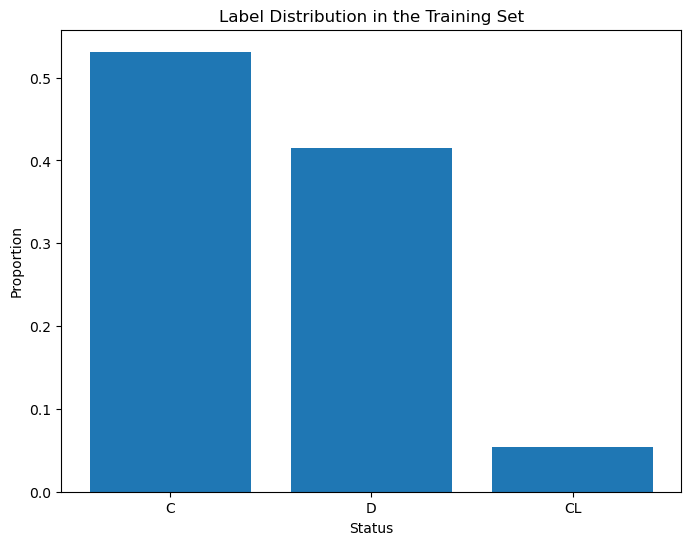

In [1]:
# 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
train_data = pd.read_csv("cirrhosis_train.csv")
test_data = pd.read_csv("cirrhosis_test.csv")

# 1.A
print("1.A")
print("Training data size:", train_data.shape)
print("Test data size:", test_data.shape)
print()

# 1.B
print("1.B")
print("Training data feature types:")
print(train_data.dtypes)
print("\nTraining data missing values:")
print(train_data.isnull().sum()[train_data.isnull().sum() > 0])
print("\nTest data feature types:")
print(test_data.dtypes)
print("\nTest data missing values:")
print(test_data.isnull().sum()[test_data.isnull().sum() > 0])
print()

# 1.C
from sklearn.impute import SimpleImputer

# Define separate imputers for numerical and categorical features
imputer_numerical = SimpleImputer(strategy="mean")
imputer_categorical = SimpleImputer(strategy="most_frequent")

# Separate the features by data type for the training set, excluding "trainID" and "Status" columns
train_features = train_data.drop(["trainID", "Status"], axis=1)
train_numerical_features = train_features.select_dtypes(include=np.number)
train_categorical_features = train_features.select_dtypes(include=object)

# Impute numerical features in the training set
imputer_numerical.fit(train_numerical_features)
train_numerical_features = pd.DataFrame(imputer_numerical.transform(train_numerical_features), columns=train_numerical_features.columns)

# Impute categorical features in the training set
imputer_categorical.fit(train_categorical_features)
train_categorical_features = pd.DataFrame(imputer_categorical.transform(train_categorical_features), columns=train_categorical_features.columns)

# Combine imputed features back into the DataFrame for the training set, including "trainID" and "Status" columns
train_df = pd.concat([train_data[["trainID", "Status"]], train_numerical_features, train_categorical_features], axis=1)

# Separate the features by data type for the test set, excluding "testID" and "Status" columns
test_features = test_data.drop(["testID", "Status"], axis=1)
test_numerical_features = test_features.select_dtypes(include=np.number)
test_categorical_features = test_features.select_dtypes(include=object)

# Impute numerical features in the test set
test_numerical_features = pd.DataFrame(imputer_numerical.transform(test_numerical_features), columns=test_numerical_features.columns)

# Impute categorical features in the test set
test_categorical_features = pd.DataFrame(imputer_categorical.transform(test_categorical_features), columns=test_categorical_features.columns)

# Combine imputed features back into the DataFrame for the test set, including "testID" column
test_df = pd.concat([test_data["testID"], test_numerical_features, test_categorical_features], axis=1)

print("1.C")
print("Missing values after imputation:")
print("Training set:", train_df.isnull().sum().sum())
print("Test set:", test_df.isnull().sum().sum())
print()

# 1.D Encoding categorical features
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
categorical_columns = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema"]

# Create a LabelEncoder object for each categorical column
label_encoders = {col: LabelEncoder() for col in categorical_columns}

# Fit the label encoders on the combined data (train + test)
for column in categorical_columns:
    combined_data = pd.concat([train_df[column], test_df[column]])
    label_encoders[column].fit(combined_data)

# Encode categorical features in the training set
for column in categorical_columns:
    train_df[column] = label_encoders[column].transform(train_df[column])

# Encode categorical features in the test set
for column in categorical_columns:
    test_df[column] = label_encoders[column].transform(test_df[column])

print("1.D")
print("Categorical features encoded using Label Encoding")
print()

# 1.E Label distribution in the training set
print("1.E")
print("Label distribution in the training set:")
label_counts = train_df["Status"].value_counts(normalize=True)
print(label_counts)

plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel("Status")
plt.ylabel("Proportion")
plt.title("Label Distribution in the Training Set")
plt.show()

2. Based on the pre-processed training data from question 1, create three supervised machine learning (ML) models for predicting “Status”.

In [19]:
# 2. Create three supervised ML models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Separate features and target variable
X = train_df.drop(["trainID", "Status"], axis=1)
y = train_df["Status"]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Create and train the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42)
}

for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    
    # Make predictions on the validation set
    y_pred = model.predict(X_val_scaled)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    
    print(f"{model_name}:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print()

Logistic Regression:
Accuracy: 0.8
Precision: 0.8
Recall: 0.8
F1-score: 0.8

Random Forest:
Accuracy: 0.8444444444444444
Precision: 0.8503831417624522
Recall: 0.8444444444444444
F1-score: 0.8336541889483067

SVM:
Accuracy: 0.8222222222222222
Precision: 0.8262371615312792
Recall: 0.8222222222222222
F1-score: 0.8121810699588476



2. A. Use an appropriate validation method, report performance score using a suitable metric. Is it possible that the presented result is an underfitted or overfitted one? Justify.

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Separate features and target variable
X = train_df.drop(["trainID", "Status"], axis=1)
y = train_df["Status"]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42)
}

# 2.a. Use k-fold cross-validation and assess underfitting/overfitting

# Define the scoring metric
scoring = make_scorer(accuracy_score)

# Perform k-fold cross-validation
k = 5
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_scaled, y, cv=k, scoring=scoring)
    
    print(f"{model_name}:")
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation score:", cv_scores.mean())
    
    # Assess underfitting/overfitting
    model.fit(X_scaled, y)
    train_score = model.score(X_scaled, y)
    print("Training score:", train_score)
    
    if abs(train_score - cv_scores.mean()) > 0.1:
        if train_score > cv_scores.mean():
            print("The model may be overfitting.")
        else:
            print("The model may be underfitting.")
    else:
        print("The model seems to be well-fitted.")
    
    print()

Logistic Regression:
Cross-validation scores: [0.73333333 0.77777778 0.68888889 0.75555556 0.75      ]
Mean cross-validation score: 0.7411111111111112
Training score: 0.8125
The model seems to be well-fitted.

Random Forest:
Cross-validation scores: [0.8        0.8        0.68888889 0.68888889 0.79545455]
Mean cross-validation score: 0.7546464646464647
Training score: 1.0
The model may be overfitting.

SVM:
Cross-validation scores: [0.82222222 0.84444444 0.68888889 0.73333333 0.77272727]
Mean cross-validation score: 0.7723232323232322
Training score: 0.8571428571428571
The model seems to be well-fitted.



    Based on the cross-validation results, the Logistic Regression and SVM models appear to be well-fitted, while the Random Forest model shows signs of overfitting. The Logistic Regression and SVM models have training scores that are slightly higher than their mean cross-validation scores, but the differences are within an acceptable threshold (0.1). This indicates that these models strike a good balance between fitting the training data and generalizing to unseen data. They are less likely to be underfitted or overfitted.

    On the other hand, the Random Forest model has a training score of 1.0, which is significantly higher than its mean cross-validation score of 0.7546. This large difference (greater than the threshold of 0.1) suggests that the Random Forest model is likely overfitting. It performs perfectly on the training data but fails to generalize well to unseen data. Overfitting occurs when a model learns the noise and specific patterns in the training data too closely, leading to poor performance on new, unseen data.

3. Use the best model that you get from question 2, do prediction on the pre-processed test set. Save your prediction (the prediction should contain two columns only: testID and Status), and submit it to the specific Kaggle in-class platform, do a screenshot of your model performance and report it.

In [25]:
# Assuming the SVM model is the best model based on the results from question 2

# Fit the SVM model on the entire scaled training data
best_model = SVC(random_state=42)
best_model.fit(X_scaled, y)

# Make predictions on the pre-processed test set
test_features = test_df.drop(["testID"], axis=1)
test_scaled = scaler.transform(test_features)
test_predictions = best_model.predict(test_scaled)

# Create a DataFrame with the predictions
submission_df = pd.DataFrame({'testID': test_df['testID'], 'Status': test_predictions})

# Save the predictions to a CSV file
submission_df.to_csv('submission.csv', index=False)

4. Analyse the importance of the features for predicting “Status” using two different approaches. Give statistical reasons of your findings.

To figure out which features are most important for predicting the "Status" variable, we can use two methods:

Correlation analysis:

    - This method looks at how strongly each feature is related to the "Status" variable.
    - We calculate correlation coefficients, which range from -1 to +1.
    - A positive value means that as the feature value goes up, the chance of a specific status goes up.
    - A negative value means that as the feature value goes up, the chance of a specific status goes down.
    - We can do statistical tests to see if the correlations are significant or just due to chance.
    - Features with stronger correlations and statistically significant results are considered more important.

Feature importance from machine learning models:

    - Some machine learning models, like Random Forest or Gradient Boosting, can tell us how much each feature contributes to the predictions.
    - We train the model on the data and get feature importance scores.
    - Features with higher scores are more important for predicting the "Status" variable.
    - We can compare the results from different models to get a better idea of which features are consistently important.
    - These models consider how features work together to make predictions.

    It's important to think about both statistical significance (is the result just due to chance?) and practical significance (does the result actually matter in the real world?). We should also use our knowledge of the problem to make sense of the results.

    By using both correlation analysis and feature importance from machine learning models, we can get a good understanding of which features are most helpful for predicting the "Status" variable. This can help us choose the best features, understand the model better, and make good decisions.